In [1]:
import mne
import pathlib
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

In [7]:
groupEvent = 'med1'

In [8]:
# read files
tdaFeaturesPaths = [f'./data/Topographical-features/{groupEvent}/dfHTR.csv',f'./data/Topographical-features/{groupEvent}/dfCTR.csv',f'./data/Topographical-features/{groupEvent}/dfVIP.csv',f'./data/Topographical-features/{groupEvent}/dfSNY.csv']
DFs = [pd.DataFrame() for _ in range(4)]
for i,path in enumerate(tdaFeaturesPaths):
    DFs[i] = pd.read_csv(path)    

In [9]:
groups = ['HTR', 'CTR', 'VIP', 'SNY']
# Generate 6 graphs comparing pairs of plots
plot_pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

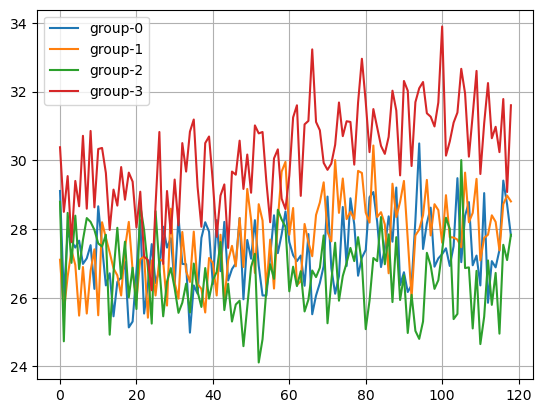

In [10]:
for i in range(4):
    plt.plot(DFs[i]['area'], label=f'group-{i}')
plt.legend()
plt.grid(True)
plt.show()

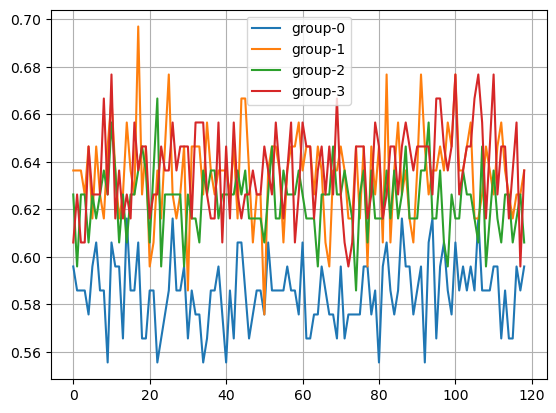

In [11]:
for i in range(4):
    plt.plot(DFs[i]['radii5'], label=f'group-{i}')
plt.legend()
plt.grid(True)
plt.show()

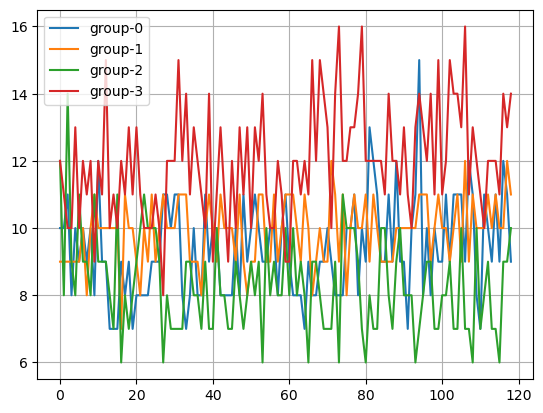

In [12]:
for i in range(4):
    plt.plot(DFs[i]['betti5'], label=f'group-{i}')
plt.legend()
plt.grid(True)
plt.show()

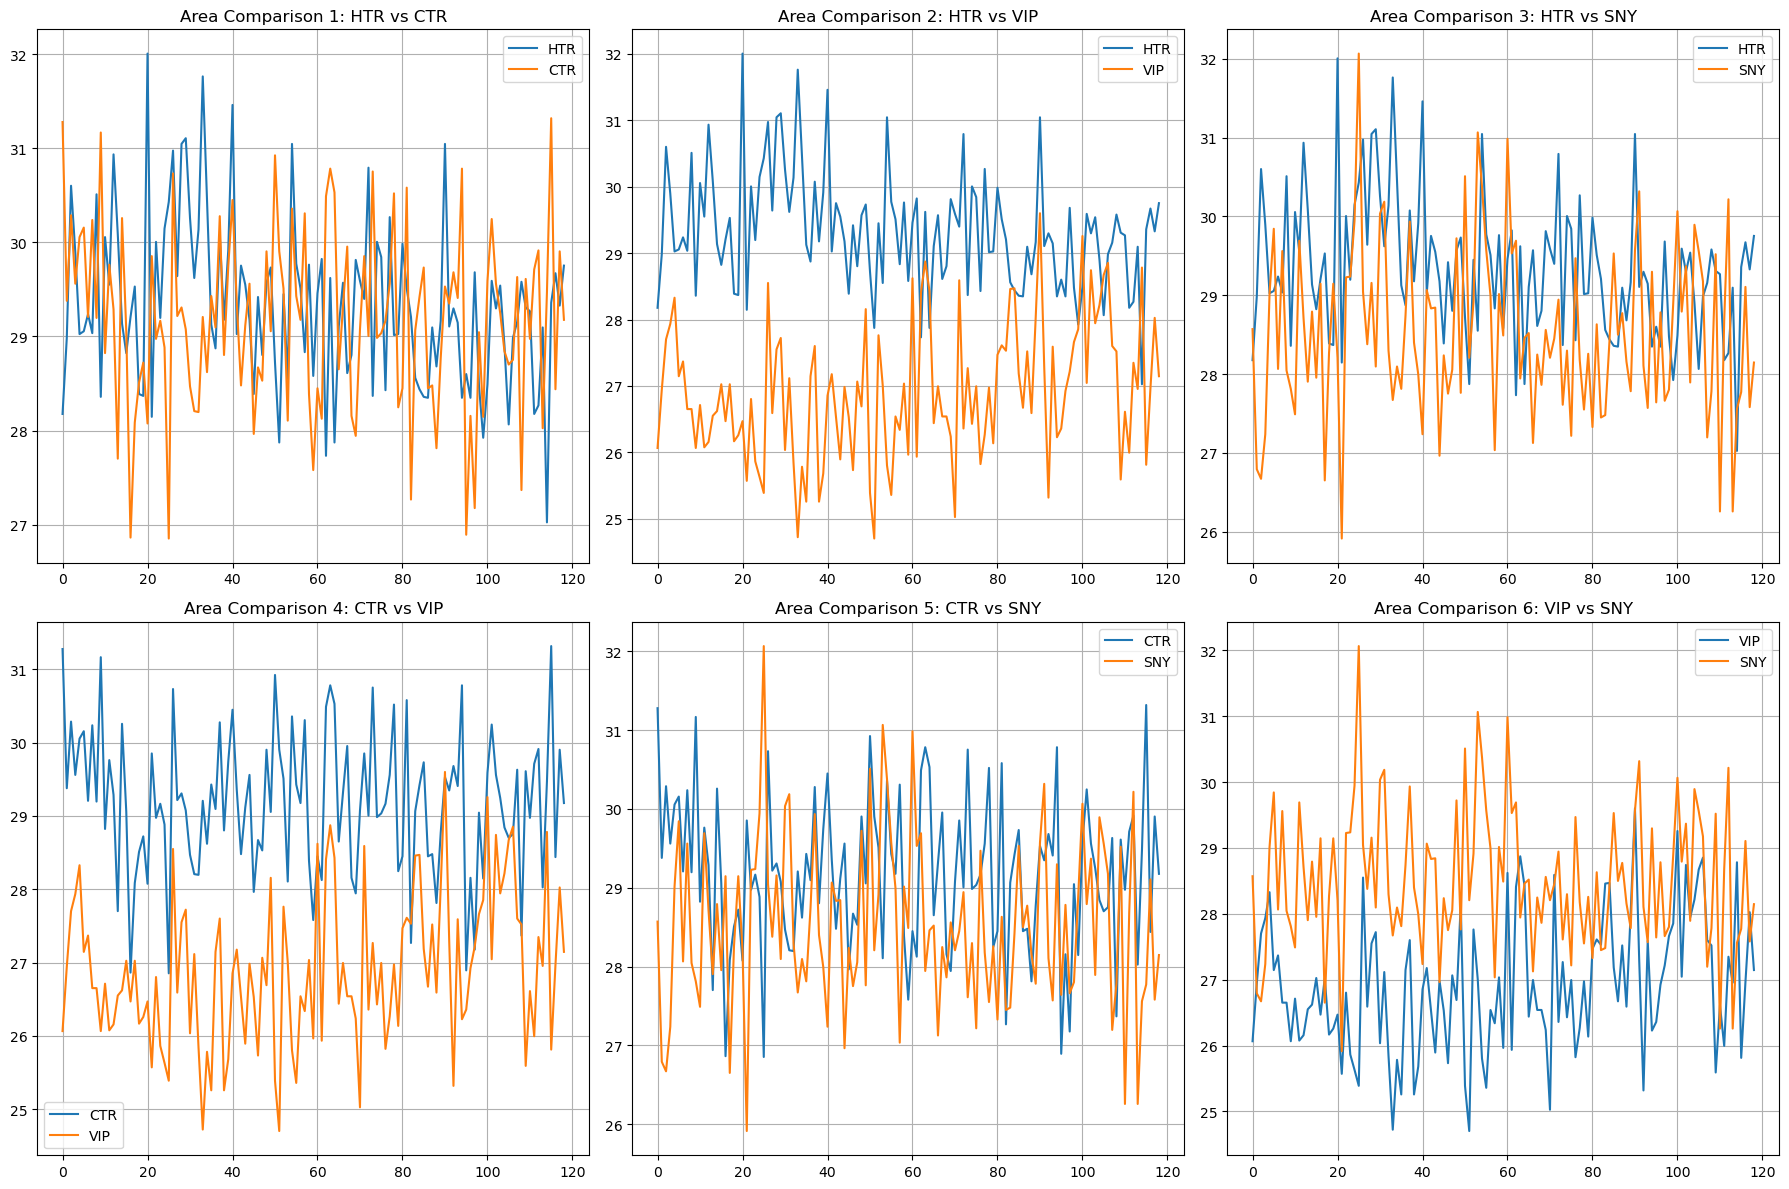

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (i, j) in enumerate(plot_pairs):
    axes[idx].plot(DFs[i]['area'], label=f'{groups[i]}')
    axes[idx].plot(DFs[j]['area'], label=f'{groups[j]}')
    axes[idx].legend()
    axes[idx].grid(True)
    axes[idx].set_title(f'Area Comparison {idx + 1}: {groups[i]} vs {groups[j]}')

plt.tight_layout()
plt.show()
fig.savefig(f'./data/Topographical-features/{groupEvent}/area_comparison.png')

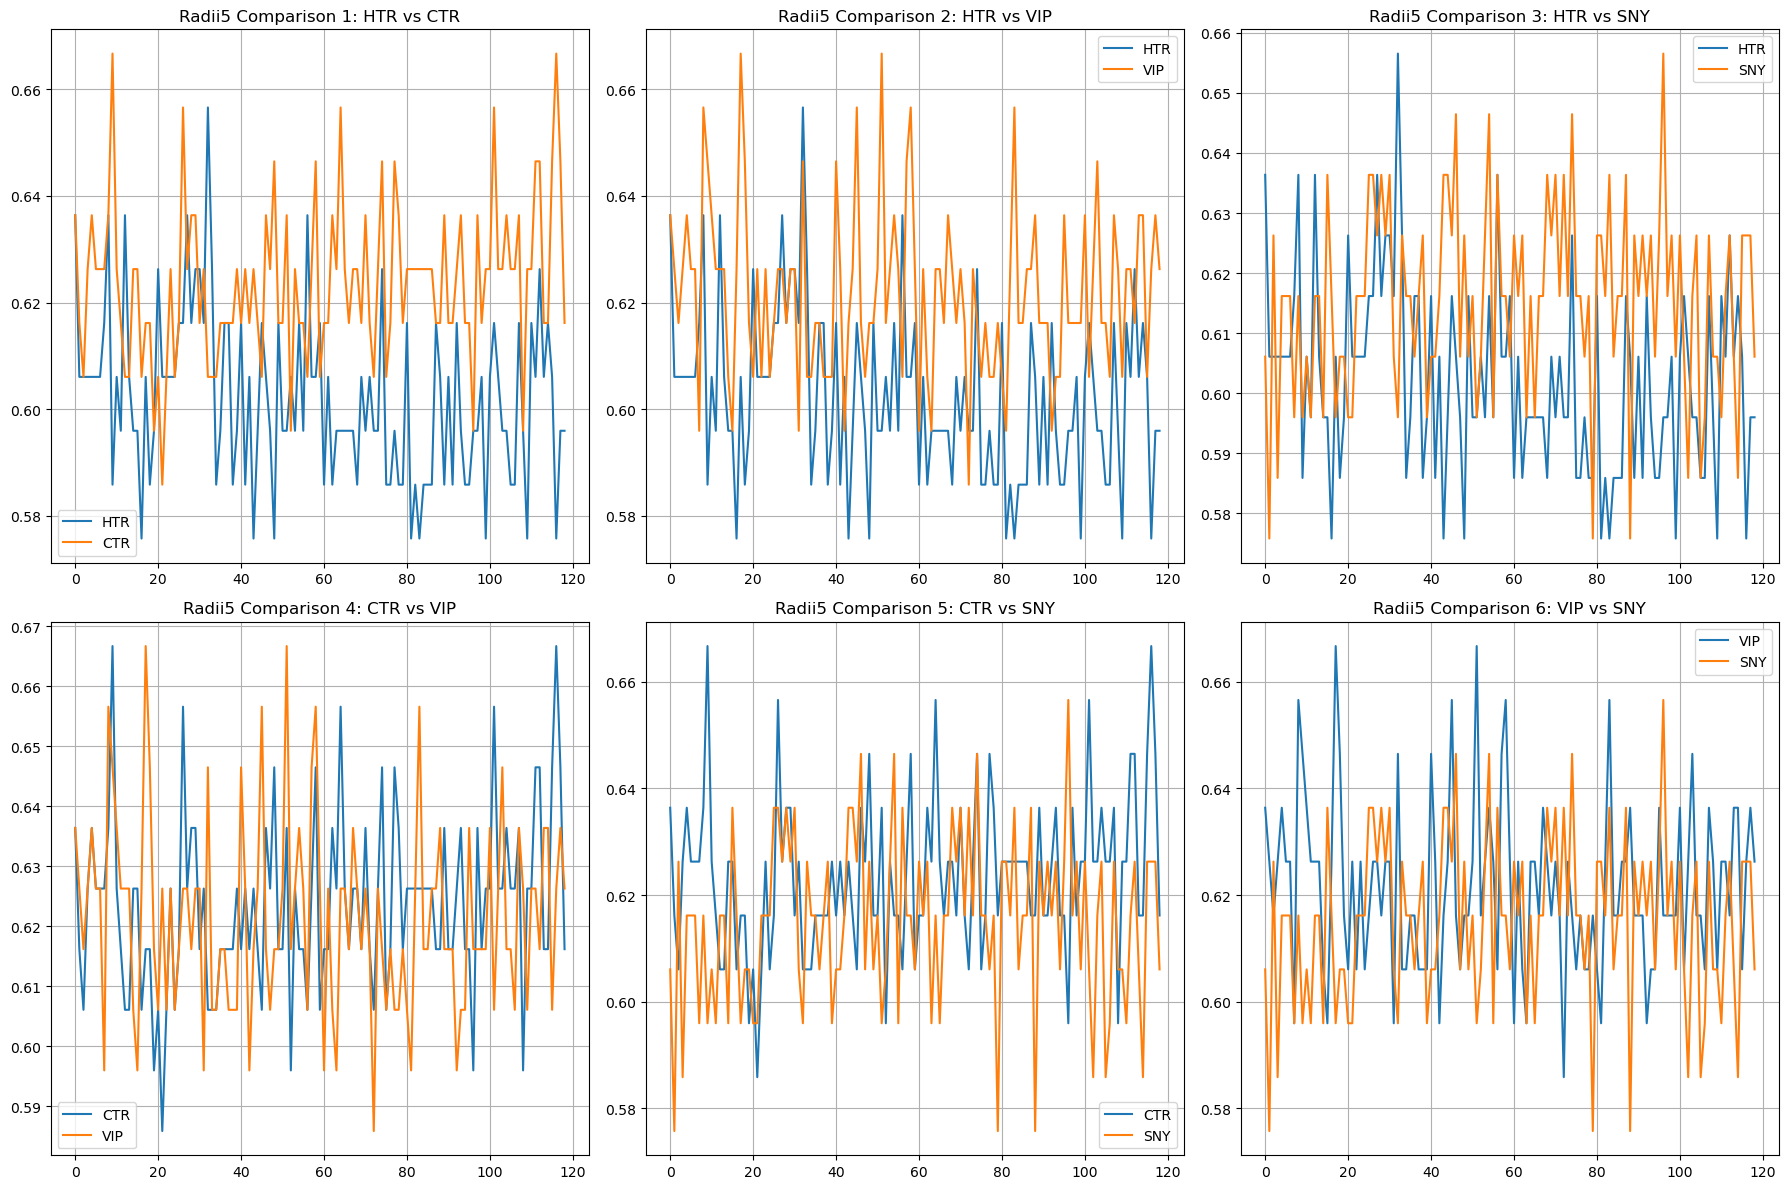

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (i, j) in enumerate(plot_pairs):
    axes[idx].plot(DFs[i]['radii5'], label=f'{groups[i]}')
    axes[idx].plot(DFs[j]['radii5'], label=f'{groups[j]}')
    axes[idx].legend()
    axes[idx].grid(True)
    axes[idx].set_title(f'Radii5 Comparison {idx + 1}: {groups[i]} vs {groups[j]}')

plt.tight_layout()
plt.show()
fig.savefig(f'./data/Topographical-features/{groupEvent}/radii5_comparison.png')

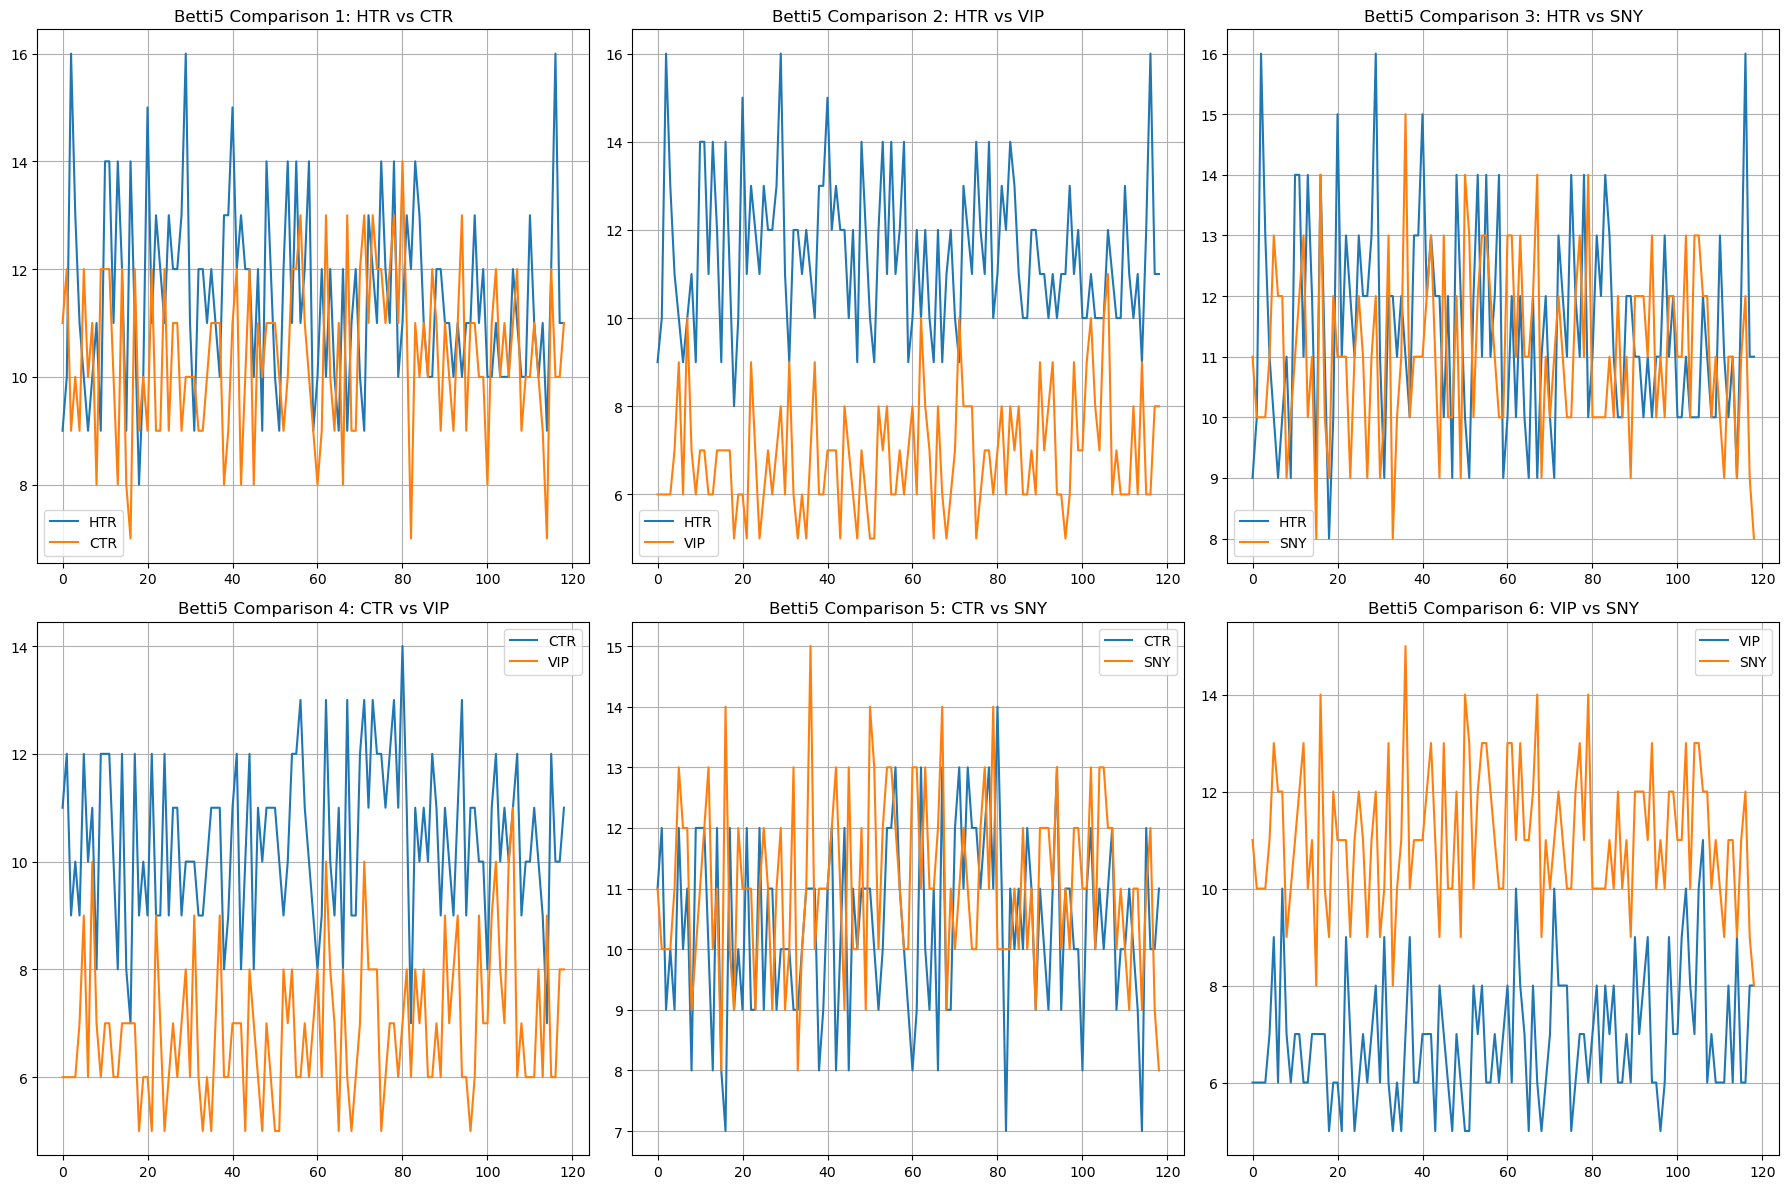

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (i, j) in enumerate(plot_pairs):
    axes[idx].plot(DFs[i]['betti5'], label=f'{groups[i]}')
    axes[idx].plot(DFs[j]['betti5'], label=f'{groups[j]}')
    axes[idx].legend()
    axes[idx].grid(True)
    axes[idx].set_title(f'Betti5 Comparison {idx + 1}: {groups[i]} vs {groups[j]}')

plt.tight_layout()
plt.show()
fig.savefig(f'./data/Topographical-features/{groupEvent}/betti5_comparison.png')

In [25]:
# read distance Matrices
paths = [f'./data/Distance-Matrix/{groupEvent}/HTR/',f'./data/Distance-Matrix/{groupEvent}/CTR/',f'./data/Distance-Matrix/{groupEvent}/VIP/',f'./data/Distance-Matrix/{groupEvent}/SNY/']
for i,path in enumerate(paths):
    paths[i] = pathlib.Path(path)
# read distance matrices
distance_matricesHTR,distance_matricesCTR,distance_matricesVIP,distance_matricesSNY = [],[],[],[]
for i in range(4):
    files = list(paths[i].glob('*.csv'))
    for j in range(119):
        files[j] = str(files[j])
    if(i==0):
        distance_matricesHTRf=files
    elif(i==1):
        distance_matricesCTRf=files
    elif(i==2):
        distance_matricesVIPf=files
    else:
        distance_matricesSNYf=files

import re
# Function to extract the number from the string
def extract_number(s):
    match = re.search(r'DmEpoch(\d+)\.csv', s)
    return int(match.group(1))  # Handle cases where there is no number

# Sort the list using the custom key
distance_matricesHTRf = sorted(distance_matricesHTRf, key=extract_number)
distance_matricesCTRf = sorted(distance_matricesCTRf, key=extract_number)
distance_matricesVIPf = sorted(distance_matricesVIPf, key=extract_number)
distance_matricesSNYf = sorted(distance_matricesSNYf, key=extract_number)

dmf = [distance_matricesHTRf,distance_matricesCTRf,distance_matricesVIPf,distance_matricesSNYf]

for i,files in enumerate(dmf):
    df119 = []
    for file in files:
        df = pd.read_csv(file).to_numpy()
        df119.append(df)
    if(i==0):
        distance_matricesHTR = df119
    elif(i==1):
        distance_matricesCTR = df119
    elif(i==2):
        distance_matricesVIP = df119
    else:
        distance_matricesSNY = df119

dm = [distance_matricesHTR,distance_matricesCTR,distance_matricesVIP,distance_matricesSNY]

In [26]:
import gudhi as gd
PERSISTENCES = [[] for _ in range(4)]
for k in range(4):
    for i in range(119):
        # Convert the distance matrix to a format that Gudhi can use
        rips_complex = gd.RipsComplex(distance_matrix=dm[k][i], max_edge_length=1)
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
        # Compute the persistence diagram
        persistence = simplex_tree.persistence()
        PERSISTENCES[k].append(persistence)

In [27]:
from collections import defaultdict
radii = np.linspace(0, 1, 100)
def get_betti_numbers(persistence, max_dim=2):
    betti_numbers = defaultdict(list)
    for radius in radii:
        counts = [0] * (max_dim + 1)
        for interval in persistence:
            dim = interval[0]
            birth, death = interval[1]
            if birth <= radius < death:
                counts[dim] += 1
        for dim in range(max_dim + 1):
            betti_numbers[dim].append(counts[dim])
    return betti_numbers

BETTI = [[] for _ in range(4)]
for k in range(4):
    for i in range(119):
        betti_numbers = get_betti_numbers(PERSISTENCES[k][i])
        BETTI[k].append(betti_numbers)

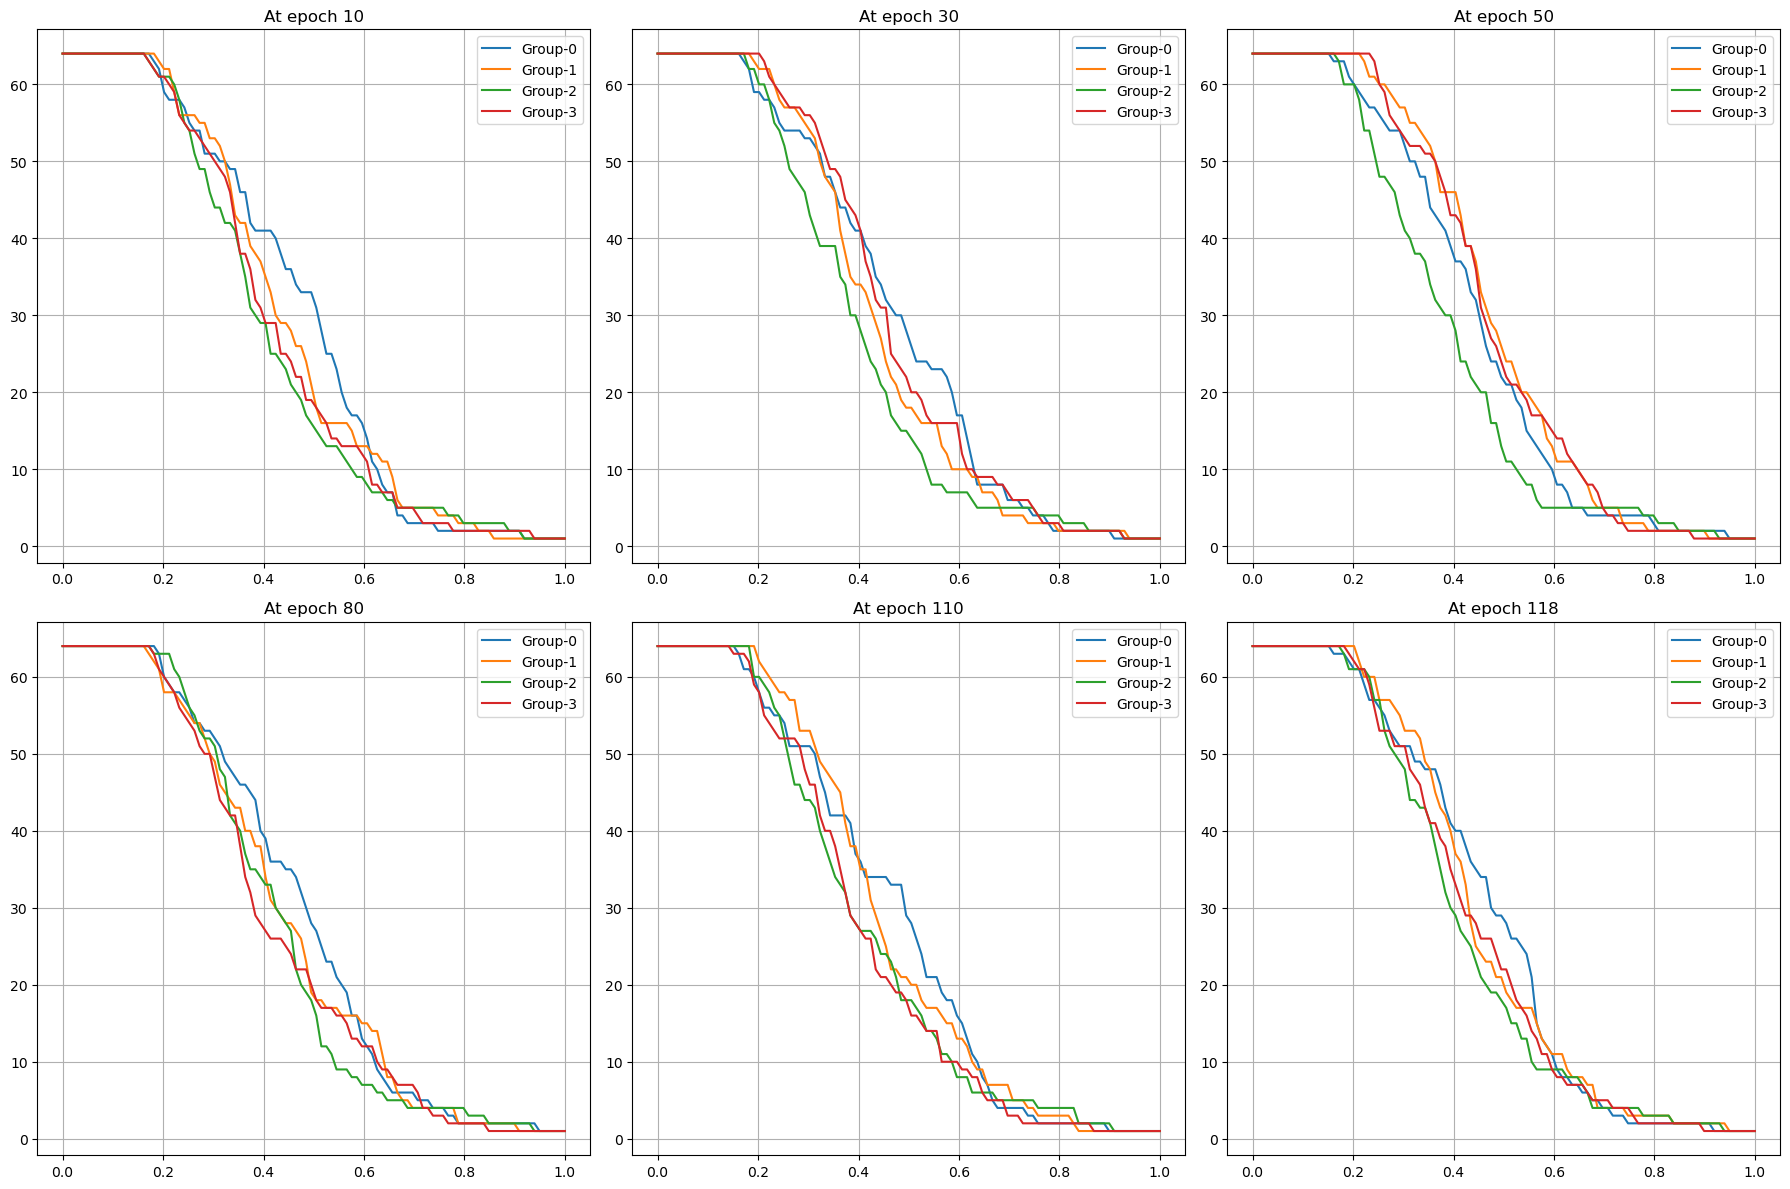

In [28]:
epochNoList = [10,30,50,80,110,118]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx,epochNo in enumerate(epochNoList):
    for i in range(4):
        axes[idx].plot(radii,BETTI[i][epochNo][0], label=f'Group-{i}')
    axes[idx].set_title(f'At epoch {epochNo}')
    axes[idx].legend()
    axes[idx].grid(True)
plt.tight_layout()
plt.show()
fig.savefig(f'./data/Topographical-features/{groupEvent}/BettiVsRadiiCurves.png')